## Notebook con pruebas de cara a la simulación. Teniendo en cuenta la cantidad de tramos y posibles combinaciones de potencias, es necesario tener un punto de partida adecuado para la simulación
No tendría sentido probar en bajadas pronunciadas con potencias muy altas, debido a que normalmente se usan para descansar, beber, etc y que al haber curvas, es posible que no puedan desarrollarse velocidades muy altas
Por otro lado, en las subidas pronunciadas, la lógica hace pensar que si los watios no son 'gastados' contra el viento, sea lógico aumentar el nivel de esfuerzo
Hay que recordar que el objetivo de esta simulación es proveer a un ciclista de un plan de competición

### Importamos librerías

In [1]:
import os
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn')
import numpy as np
import plotly.graph_objs as go
import ipywidgets as widgets
import plotly as py
import math as mt
py.offline.init_notebook_mode(connected=True)

### Cargamos los datos

In [2]:
path = '../Entrenamientos/Procesado_Tramos.xlsx'

In [3]:
df = pd.read_excel(path)

In [4]:
df.describe()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum
count,1566.000000,1566.000000,1566.000000,1564.000000,1566.000000,1566.000000,1566.000000,1563.000000,1566.000000,1566.000000
mean,88.273946,3193.413155,3237.544700,172.841148,77.945083,604.974227,inf,-0.523086,NaN,43956.065230
std,74.367035,2006.879552,2007.195839,58.752558,163.853506,990.936845,NaN,15.893856,NaN,27597.295988
min,0.000000,0.000000,5.000000,0.000000,-19.000000,0.000000,-5.142857,-30.119336,-inf,63.000000
25%,35.000000,1533.000000,1561.250000,138.296295,6.000000,50.337673,25.886720,-11.651183,-0.673262,20811.460000
50%,71.000000,3030.000000,3163.000000,180.189194,39.000000,328.367595,31.469712,-0.671048,-0.001459,42480.000000
75%,116.000000,4783.000000,4819.000000,215.477559,78.000000,682.200031,37.867565,11.295255,0.582053,65076.261277
max,345.000000,7796.000000,7830.000000,394.699287,2747.000000,10273.070042,inf,29.972648,inf,107610.184614


### Filtramos outliers

In [5]:
df = df[df["viento_aparente"]!=-np.inf]
df = df[df["porc"]!=np.inf]
df["puntos_en_tramo"]= df["tramo_final"]-df["tramo_inicial"]
df = df[df["puntos_en_tramo"]>10]
df = df[df["dist"]>400]

In [6]:
df.describe()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum,puntos_en_tramo
count,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000
mean,75.742898,3236.553977,3324.062500,170.397681,155.754261,1197.764171,31.884690,0.206131,-0.013950,45182.282085,87.508523
std,62.024779,2032.023813,2030.134928,61.189771,220.168319,1236.629743,8.927396,12.940261,2.313670,27986.826277,91.780336
min,0.000000,0.000000,65.000000,1.742131,34.000000,400.613923,11.618577,-29.536164,-6.677410,624.000000,23.000000
25%,29.000000,1518.000000,1589.750000,126.828829,60.000000,529.620097,24.830482,-8.474684,-1.760643,21362.893919,37.000000
50%,65.000000,3036.500000,3205.000000,181.767777,86.000000,741.350014,31.938754,0.320381,-0.367563,44029.333291,54.000000
75%,105.000000,4792.000000,4843.500000,221.011141,160.000000,1220.595748,38.095553,8.653271,1.735269,66243.249904,91.000000
max,345.000000,7796.000000,7830.000000,278.991626,2747.000000,10273.070042,69.830249,29.517057,7.137195,107610.184614,796.000000


In [7]:
df.head()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum,prueba,puntos_en_tramo
8,8,136,164,73.327512,49,412.000000,30.269388,6.109815,-1.811555,1413.000000,20180225_LEVS_195_90_R_E.gpx,28
13,13,190,222,206.796051,64,454.289186,25.553767,6.258684,1.412053,2271.000000,20180225_LEVS_195_90_R_E.gpx,32
14,14,222,281,127.358925,74,774.757500,37.690905,8.309926,-1.323913,3049.515185,20180225_LEVS_195_90_R_E.gpx,59
15,15,281,394,227.806936,226,1931.242500,30.763155,6.478255,1.227197,4979.000000,20180225_LEVS_195_90_R_E.gpx,113
17,17,414,700,229.792174,594,3826.821790,23.192859,3.383788,2.599847,9105.681852,20180225_LEVS_195_90_R_E.gpx,286


## Análisis Gráfico

In [8]:
def show_graph(cda,por,wind):

    V = np.arange(0,60,0.5)

    ro = 1.2
    #cda = 0.3
    cr = 0.0033
    m = 90
    g = 9.81
    s = mt.sin(mt.atan(por/100))

    Pa = ro/2*cda*((V/3.6)+(wind/3.6))**2*(V/3.6)
    Pr = (cr)*m*g*(V/3.6)
    Pg = (s)*m*g*(V/3.6)
    Pt = Pa + Pr + Pg

    trace0 = go.Scatter(
        x=V,
        y=Pa,
        mode='lines',
        name='Pot_aerodinamica'
    )

    trace1 = go.Scatter(
        x=V,
        y=Pr,
        mode='lines',
        name='Pot_rozamiento'
    )

    trace2 = go.Scatter(
        x=V,
        y=Pg,
        mode='lines',
        name='Pot_pendinte'
    )
    
    trace3 = go.Scatter(
        
        x=V,
        y=Pt,
        mode='lines',
        name='Pot_total'
    )
    
    layout = go.Layout(title='Simulador de potencia')
    
    data = [trace0, trace1, trace2, trace3]

    fig = dict(data=data, layout=layout)

    py.offline.iplot(fig)
widgets.interact(show_graph, cda=(0.1,0.5,0.05), por=(-10,10,0.5), wind=(-15,15,1))

<function __main__.show_graph>

Usamos Seaborn

In [9]:
import seaborn as sns

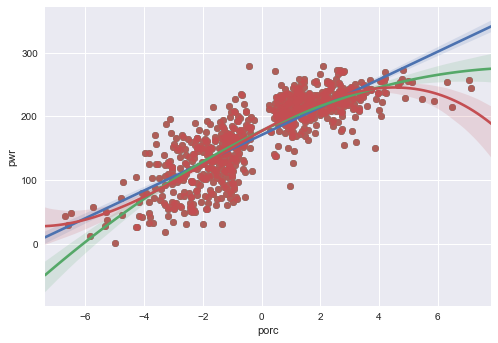

In [10]:
sns.regplot(x = 'porc', y = 'pwr', data=pd.DataFrame(df[['porc','pwr']]),order=1)
sns.regplot(x = 'porc', y = 'pwr', data=pd.DataFrame(df[['porc','pwr']]),order=2)
sns.regplot(x = 'porc', y = 'pwr', data=pd.DataFrame(df[['porc','pwr']]),order=3)
#sns.regplot(x = 'porc', y = 'pwr', data=pd.DataFrame(df[['porc','pwr']]),robust=True)

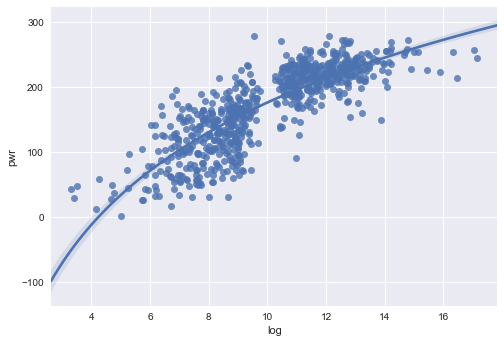

In [11]:
df['log']=df['porc']+10 #para trasladar el eje x y que no de error el log
sns.regplot(x = 'log', y = 'pwr', data=pd.DataFrame(df[['log','pwr']]),logx=True)

Teniendo en cuenta los gráficos anteriores, se podría modelar la potencia en función del porcentaje como una sigmoide
Esto es debido a que en la simulación se va a considerar una potencia mínima y una máxima que no deben ser sobrepasadas
Por otro lado, el crecimiento de la potencia se parece a la función polinómica de grado 3

In [12]:
pot_min = 50
pot_max = 300
ff_1 = 0.5
ff_2 = 0.5
porc = np.arange(-10,10,0.5)
potencia = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))


trace = go.Scatter(        
        x=porc,
        y=potencia,
        mode='lines',
        name='Potencia')
    
layout = go.Layout(title='Sigmoide de potencia')

data = [trace]

fig = dict(data=data, layout=layout)

py.offline.iplot(fig)

In [ ]:
sns.regplot(x = 'spd', y = 'pwr', data=pd.DataFrame(df[['spd','pwr']]),order=1)
sns.regplot(x = 'spd', y = 'pwr', data=pd.DataFrame(df[['spd','pwr']]),order=2)
sns.regplot(x = 'spd', y = 'pwr', data=pd.DataFrame(df[['spd','pwr']]),order=3)

In [ ]:
sns.regplot(x = 'viento_aparente', y = 'pwr', data=pd.DataFrame(df[['viento_aparente','pwr']]),order=1)
sns.regplot(x = 'viento_aparente', y = 'pwr', data=pd.DataFrame(df[['viento_aparente','pwr']]),order=2)
sns.regplot(x = 'viento_aparente', y = 'pwr', data=pd.DataFrame(df[['viento_aparente','pwr']]),order=3)
sns.regplot(x = 'viento_aparente', y = 'pwr', data=pd.DataFrame(df[['viento_aparente','pwr']]),robust=True)

Con Matplotlib

In [ ]:
plt.subplot(1,3,1)
plt.scatter(df['porc'],df['pwr'])

plt.subplot(1,3,2)
plt.scatter(df['spd'],df['pwr'])

plt.subplot(1,3,3)
plt.scatter(df['viento_aparente'],df['pwr'])

In [ ]:
from sklearn import datasets, linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
df_lm = df[['pwr','porc']]
df_lm

In [ ]:
plt.scatter(df_lm['porc'],df_lm['pwr'])

In [ ]:
df_lm_x = df_lm[['porc']]
df_lm_y = df_lm[['pwr']]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df_lm_x, df_lm_y, test_size=0.30, random_state=42)

In [ ]:
X_train

#### Robust Scaler

from sklearn.preprocessing import RobustScaler

model_rs = RobustScaler()

X_train_rs = model_rs.fit_transform(X_train)

X_test_rs = model_rs.transform(X_test)

### Modelo Lineal

In [ ]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(X_train,Y_train)

Y_pred = regr.predict(X_test)

In [ ]:
print(metrics.mean_squared_error(Y_test,Y_pred))
print(metrics.explained_variance_score(Y_test, Y_pred))

In [ ]:
regr.coef_

In [ ]:
regr.intercept_

In [ ]:
X_test

In [ ]:
X_test['Y_poly'] = X_test['porc'].apply(lambda x: x*regr.coef_ + regr.intercept_)

In [ ]:
X_test['Y_pred'] = Y_pred

In [ ]:
X_test

In [ ]:
from sklearn.externals import joblib
joblib.dump(regr, "regr_porc_pwr.model")